
## DESCRIPTION

This notebook plots the results of the GLMM with the lowest AIC.

Best model is model27.

We use R to produce the plots

***
### SETUP

Load the setup script

In [1]:
from utils.common_setup import *

Import the cleaned dataset

In [2]:
data_folder = os.path.join(os.getcwd(), '..', 'data')
data = pd.read_csv(os.path.join(data_folder, 'clean_data.csv'))

Import the best model

In [3]:
project_root = os.path.dirname(os.getcwd())
output_dir = os.path.join(project_root, 'outputs')    
filepath = os.path.join(output_dir, "best_model.joblib")

model = load_model(filepath = filepath)

Activate R interface

In [4]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr

# pandas <-> R conversion
pandas2ri.activate()

%load_ext rpy2.ipython

Pass the fitted model and the data from pymer4 to R using rpy2

In [19]:
# Python model to R object
#ro.globalenv['model'] = model.model_obj

# Python data to R object
ro.globalenv['data'] = pandas2ri.py2rpy(data)


Load R libraries and random effects as factors

In [20]:
%%R
library(lme4)
library(ggplot2)
library(ggpubr)
library(performance)
library(viridis)

data$region <- as.factor(data$region)
data$operation_id <- as.factor(data$operation_id)
data$season <- as.factor(data$season)
data$death_next_season <- as.integer(ifelse(data$death_next_season == FALSE, 0, 1))

Import the best model directly in R

In [7]:
%%R
file_path1 <- file.path("..", "outputs", "best_model.rds")
file_path2 <- file.path("..", "outputs", "best_model_refit.rds")

model <- readRDS(file_path1)
refit_model <- readRDS(file_path2)


### PLOT MODEL

#### O3 average

Generate predictions for O3

Cut extreme values

In [162]:
%%R
# New data for predictions
new_data <- data.frame(
    o3_average = seq(min(data$o3_average), max(data$o3_average), length.out=100),
    #o3_average = seq(0, max(data$o3_average), length.out=100),
    ndvi_average = mean(data$ndvi_average),
    wspd_average = mean(data$wspd_average)
)

# Predictions
preds <- predict(
    model,
    new_data,
    re.form=NA,
    se.fit=TRUE
)

new_data$fit <- preds$fit
new_data$se <- preds$se.fit
new_data$ci_lower <- new_data$fit - 1.96 * new_data$se
new_data$ci_upper <- new_data$fit + 1.96 * new_data$se

In addition: Warning message:
In predict.merMod(model, new_data, re.form = NA, se.fit = TRUE) :
  se.fit computation uses an approximation to estimate the sampling distribution of the parameters


Plot predictions

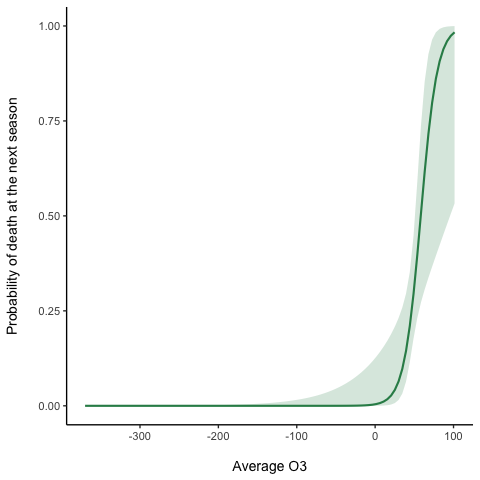

In [163]:
%%R
p <- ggplot(new_data, aes(x=o3_average, y=plogis(fit))) +
        geom_line(color="seagreen", linewidth = 1) +
        geom_ribbon(aes(ymin=plogis(ci_lower), ymax=plogis(ci_upper)), alpha=0.2, fill="seagreen") +
        scale_y_continuous(breaks = seq(0,1,0.25), limits = c(0,1)) +
        labs(x="\nAverage O3", y="Probability of death at the next season\n") +
        theme_classic(base_size = 14) +
        theme(panel.grid = element_blank())
p

Investigate extreme observations.

They come from Canada in 2023. Will remove them from the analysis

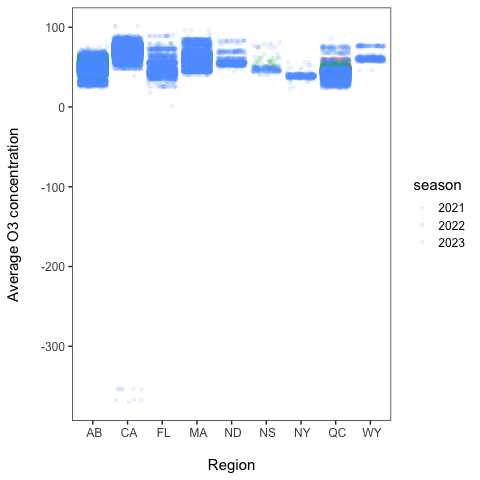

In [38]:
%%R
ggplot(data = data, aes(x = region, y = o3_average, colour = season))+
    geom_jitter(alpha = 0.1) +
    ylab("Average O3 concentration\n") +
    xlab("\nRegion") +
    theme_bw(base_size = 15) +
    theme(panel.grid = element_blank())

### REFIT MODEL

We refit the model without the extremes in Canada.

In [21]:
%%R
# Remove extremes
filtered_data <- data[data$o3_average >=0, ]

In [22]:
%%R
# Update model with filtered data
refit_model <- update(model, data = filtered_data)

# Save the output
filename <- file.path("..", "outputs", "best_model_refit.rds")
saveRDS(refit_model, filename)

In [23]:
%%R
summary(refit_model)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: death_next_season ~ ndvi_average * o3_average + wspd_average +  
    (o3_average | operation_id)
   Data: filtered_data
Control: 
structure(list(optimizer = c("bobyqa", "Nelder_Mead"), restart_edge = FALSE,  
    boundary.tol = 1e-05, calc.derivs = TRUE, use.last.params = FALSE,  
    checkControl = list(check.nobs.vs.rankZ = "ignore", check.nobs.vs.nlev = "stop",  
        check.nlev.gtreq.5 = "ignore", check.nlev.gtr.1 = "stop",  
        check.nobs.vs.nRE = "stop", check.rankX = "message+drop.cols",  
        check.scaleX = "warning", check.formula.LHS = "stop",  
        check.response.not.const = "stop"), checkConv = list( 
        check.conv.grad = list(action = "warning", tol = 0.002,  
            relTol = NULL), check.conv.singular = list(action = "message",  
            tol = 1e-04), check.conv.hess = list(action = "warning",  
            tol =

### ASSESS MODEL FIT

In [64]:
%%R
model_performance(refit_model)

# Indices of model performance

AIC       |      AICc |       BIC | R2 (cond.) | R2 (marg.) |   ICC |  RMSE | Sigma | Log_loss | Score_log | Score_spherical
----------------------------------------------------------------------------------------------------------------------------
1.289e+05 | 1.289e+05 | 1.289e+05 |      0.730 |      0.152 | 0.682 | 0.440 | 1.000 |    0.571 |      -Inf |       1.007e-04


### PLOT REFIT MODEL

#### Plot mean O3

In [51]:
%%R
# New data for predictions
new_data1 <- data.frame(
    o3_average = seq(
        min(filtered_data$o3_average),
        max(filtered_data$o3_average),
        length.out = 100
    ),
    ndvi_average = mean(filtered_data$ndvi_average),
    wspd_average = mean(filtered_data$wspd_average)
)

# Predictions
preds <- predict(
    refit_model,
    new_data1,
    re.form = NA,
    se.fit = TRUE
)

new_data1$fit <- preds$fit
new_data1$se <- preds$se.fit
new_data1$ci_lower <- new_data1$fit - 1.96 * new_data1$se
new_data1$ci_upper <- new_data1$fit + 1.96 * new_data1$se

In addition: Warning message:
In predict.merMod(refit_model, new_data1, re.form = NA, se.fit = TRUE) :
  se.fit computation uses an approximation to estimate the sampling distribution of the parameters


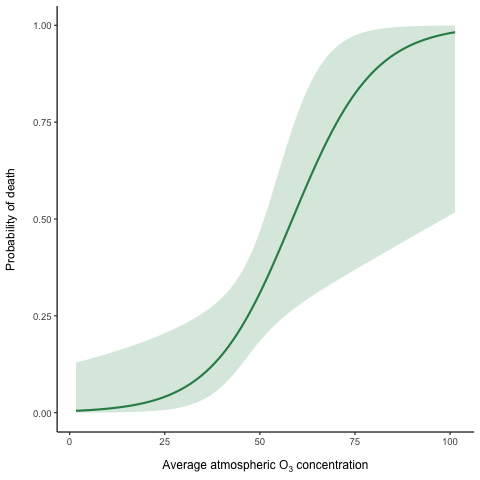

In [100]:
%%R
p1 <- ggplot(new_data1, aes(x = o3_average, y = plogis(fit))) +
        geom_line(color = "seagreen", linewidth = 1) +
        geom_ribbon(
           aes(ymin = plogis(ci_lower), ymax = plogis(ci_upper)),
           alpha = 0.2,
           fill = "seagreen"
        ) +
        scale_y_continuous(breaks = seq(0,1,0.25), limits = c(0,1)) +
        labs(
           x = expression("Average atmospheric O"[3] * " concentration"),
           y = "Probability of death\n"
        ) +
        theme_classic(base_size = 12) +
        theme(
         panel.grid = element_blank(),
         axis.title.x = element_text(margin = margin(t = 14))
        )
p1

### Plot mean ndvi

In [53]:
%%R
# New data for predictions
new_data2 <- data.frame(
    ndvi_average = seq(
        min(filtered_data$ndvi_average),
        max(filtered_data$ndvi_average),
        length.out = 100
    ),
    o3_average = mean(filtered_data$o3_average),
    wspd_average = mean(filtered_data$wspd_average)
)

# Predictions
preds <- predict(
    refit_model,
    new_data2,
    re.form = NA,
    se.fit = TRUE
)

new_data2$fit <- preds$fit
new_data2$se <- preds$se.fit
new_data2$ci_lower <- new_data2$fit - 1.96 * new_data2$se
new_data2$ci_upper <- new_data2$fit + 1.96 * new_data2$se

In addition: Warning message:
In predict.merMod(refit_model, new_data2, re.form = NA, se.fit = TRUE) :
  se.fit computation uses an approximation to estimate the sampling distribution of the parameters


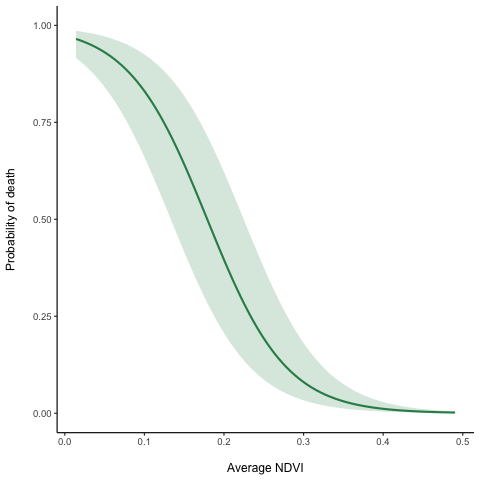

In [54]:
%%R
p2 <- ggplot(new_data2, aes(x = ndvi_average, y = plogis(fit))) +
        geom_line(color = "seagreen", linewidth = 1) +
        geom_ribbon(
           aes(ymin = plogis(ci_lower), ymax = plogis(ci_upper)),
           alpha = 0.2,
           fill = "seagreen"
        ) +
        scale_y_continuous(breaks = seq(0,1,0.25), limits = c(0,1)) +
        labs(x = "\nAverage NDVI", y = "Probability of death\n") +
        theme_classic(base_size = 12) +
        theme(panel.grid = element_blank())
p2

#### Plot interaction

In [30]:
%%R
# Get mean and standard deviation of ndvi_average
ndvi_mean <- mean(filtered_data$ndvi_average, na.rm = TRUE)
ndvi_sd <- sd(filtered_data$ndvi_average, na.rm = TRUE)

# Create a sequence of o3_average values
o3_seq <- seq(
  min(filtered_data$o3_average, na.rm = TRUE),
  max(filtered_data$o3_average, na.rm = TRUE),
  length.out = 100
)

# new data frame for predictions
new_data3 <- data.frame(
  o3_average = rep(o3_seq, 3),
  ndvi_average = c(rep(ndvi_mean, 100), 
                   rep(ndvi_mean - 2 * ndvi_sd, 100), 
                   rep(ndvi_mean + 2 * ndvi_sd, 100)),
  wspd_average = mean(filtered_data$wspd_average, na.rm = TRUE)
)

# Add a label
new_data3$ndvi_level <- factor(
  rep(c("Average", "Avg. -2 SD", "Avg. +2 SD"),
  each = 100)
)

In [31]:
%%R
new_data3$predicted <- predict(
    refit_model,
    newdata = new_data3,
    re.form = NA,
    type = "response"
)

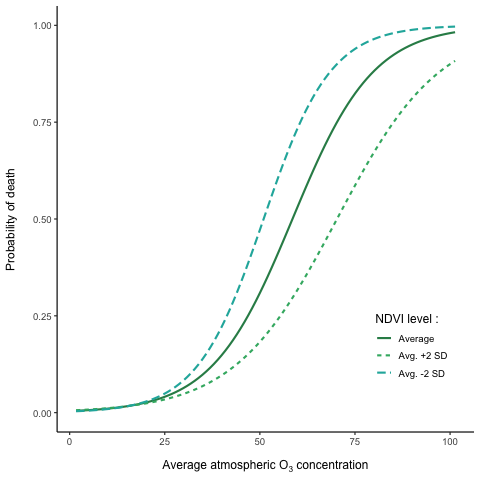

In [79]:
%%R
palette <- c("#2E8B57", "#3CB371", "#20B2AA")

p3 <- ggplot(new_data3, aes(x = o3_average, y = predicted)) +
  geom_line(aes(linetype = ndvi_level, color = ndvi_level), linewidth = 1) +
  scale_y_continuous(breaks = seq(0,1,0.25), limits = c(0,1)) +
  scale_color_manual(values = palette) +
  labs(
    x = expression("Average atmospheric O"[3] * " concentration"),
    y = "Probability of death\n",
    color = "NDVI level :",
    linetype = "NDVI level :"
    ) +
  theme_classic(base_size = 12) +
  theme(
    panel.grid = element_blank(),
    legend.position = c(0.85, 0.2),
    legend.background = element_blank(),
    axis.title.x = element_text(margin = margin(t = 14))
  )
p3

In [82]:
%%R
# Get mean and standard deviation of o3_average
o3_mean <- mean(filtered_data$o3_average, na.rm = TRUE)
o3_sd <- sd(filtered_data$o3_average, na.rm = TRUE)

# Create a sequence of ndvi_average values
ndvi_seq <- seq(
  min(filtered_data$ndvi_average, na.rm = TRUE),
  max(filtered_data$ndvi_average, na.rm = TRUE),
  length.out = 100
)

# New data frame for predictions
new_data4 <- data.frame(
  ndvi_average = rep(ndvi_seq, 3),
  o3_average = c(rep(o3_mean, 100), 
                 rep(o3_mean - 2 * o3_sd, 100), 
                 rep(o3_mean + 2 * o3_sd, 100)),
  wspd_average = mean(filtered_data$wspd_average, na.rm = TRUE)
)

# Add a label
new_data4$o3_level <- factor(
  rep(c("Average", "-2 SD", "+2 SD"),
  each = 100)
)

In [83]:
%%R
new_data4$predicted <- predict(
    refit_model,
    newdata = new_data4,
    re.form = NA,
    type = "response"
)

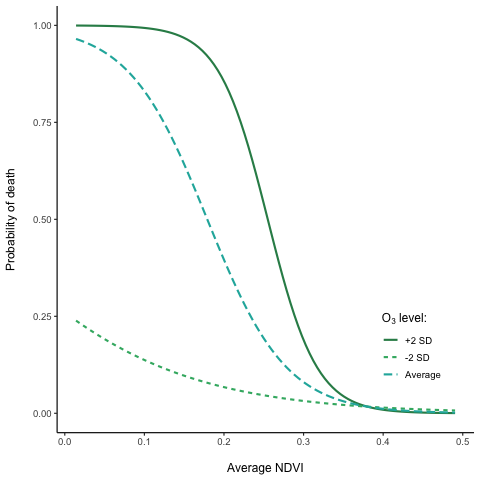

In [84]:
%%R
palette <- c("#2E8B57", "#3CB371", "#20B2AA")

p6 <- ggplot(new_data4, aes(x = ndvi_average, y = predicted)) +
  geom_line(aes(linetype = o3_level, color = o3_level), linewidth = 1) +
  scale_y_continuous(breaks = seq(0,1,0.25), limits = c(0,1)) +
  scale_color_manual(values = palette) +
  labs(
    x = "\nAverage NDVI",
    y = "Probability of death\n",
    color = expression("O"[3] * " level:"),
    linetype = expression("O"[3] * " level:")
    ) +
  theme_classic(base_size = 12) +
  theme(
    panel.grid = element_blank(),
    legend.position = c(0.85, 0.2),
    legend.background = element_blank()
  )
p6

In [85]:
%%R
# Create a grid of o3_average and ndvi_average values
o3_seq <- seq(
  min(filtered_data$o3_average, na.rm = TRUE),
  max(filtered_data$o3_average, na.rm = TRUE),
  length.out = 100
)

ndvi_seq <- seq(
  min(filtered_data$ndvi_average, na.rm = TRUE),
  max(filtered_data$ndvi_average, na.rm = TRUE),
  length.out = 100
)

# Create a data frame with all combinations of o3 and ndvi
grid_data <- expand.grid(
  o3_average = o3_seq,
  ndvi_average = ndvi_seq,
  wspd_average = mean(filtered_data$wspd_average, na.rm = TRUE)
)

In [86]:
%%R
# Generate predictions based on the grid
grid_predictions <- predict(
    refit_model,
    newdata = grid_data,
    re.form = NA,
    se.fit = TRUE
)

# Add predictions to the grid data
grid_data$predicted <- plogis(grid_predictions$fit)

In addition: Warning message:
In predict.merMod(refit_model, newdata = grid_data, re.form = NA,  :
  se.fit computation uses an approximation to estimate the sampling distribution of the parameters


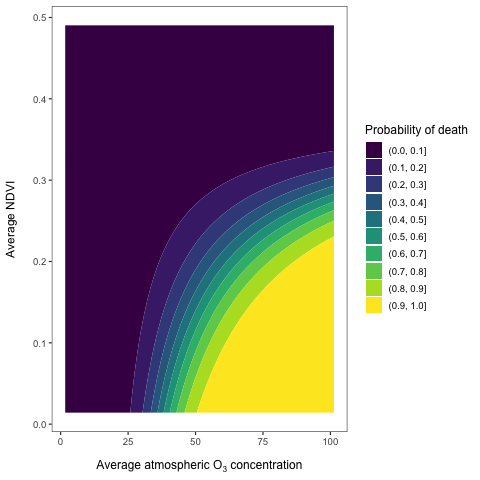

In [90]:
%%R
p7 <- ggplot(grid_data, aes(x = o3_average, y = ndvi_average, z = predicted)) +
  geom_contour_filled(bins = 10) +
  #scale_fill_gradient()) +
  labs(
    x = expression("Average atmospheric O"[3] * " concentration"),
    y = "Average NDVI\n",
    fill = "Probability of death"
  ) +
  theme_bw(base_size = 12) +
  theme(
    panel.grid = element_blank(),
    axis.title.x = element_text(margin = margin(t = 14))
    )
p7

#### Plot random slopes

1. Extract fixed effects (intercept and slope)
2. Extract random effects (random intercepts and slopes for each operation_id)
3. Create a sequence of O3 values

In [94]:
%%R
fixed_effects <- fixef(refit_model)
random_effects <- ranef(refit_model)$operation_id

# Sequence of values for o3_average
o3_seq <- seq(
  min(filtered_data$o3_average, na.rm = TRUE),
  max(filtered_data$o3_average, na.rm = TRUE),
  length.out = 100
)


Prepare a predictions dataset for every operation_id

In [95]:
%%R
# Empty data frame to store predictions
predictions_data <- data.frame()

# Loop through each operation_id to calculate the predicted values
for (op_id in rownames(random_effects)) {
  
  # Random intercept and slope for given operation_id
  random_intercept <- random_effects[op_id, "(Intercept)"]
  random_slope <- random_effects[op_id, "o3_average"]
  
  # Calculate true intercept and slope (fixed + random)
  total_intercept <- fixed_effects["(Intercept)"] + random_intercept
  total_slope <- fixed_effects["o3_average"] + random_slope
  
  # Create predicted values for given operation_id
  predicted_values <- total_intercept + total_slope * o3_seq
  
  # Create a data frame to store predictions
  temp_df <- data.frame(
    o3_average = o3_seq,
    predicted = plogis(predicted_values), # back-transform
    operation_id = op_id
  )
  
  # Append to predictions_data
  predictions_data <- rbind(predictions_data, temp_df)
}

Add the region to plot by region

In [96]:
%%R
predictions_data <- merge(
    predictions_data,
    filtered_data[, c("operation_id", "region")],
    by = "operation_id",
    all.x = TRUE
)

Plot for all without regions

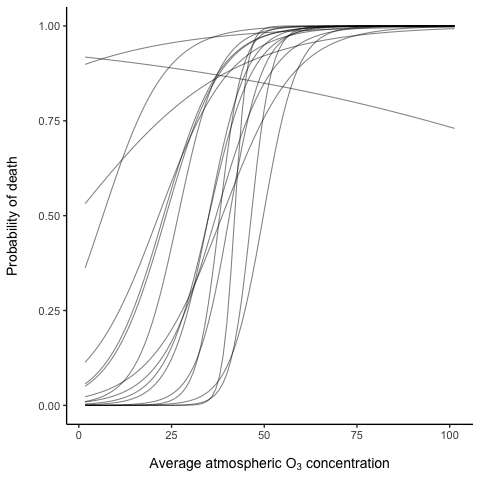

In [97]:
%%R
p4 <- ggplot(predictions_data, aes(x = o3_average, y = predicted, group = operation_id)) +
  geom_line(alpha = 0.5) +
  labs(
    x = expression("Average atmospheric O"[3] * " concentration"),
    y = "Probability of death\n"
  ) +
  scale_y_continuous(breaks = seq(0, 1, 0.25), limits = c(0, 1)) +
  theme_classic(base_size = 14) +
  theme(
    legend.position = "none",
    axis.title.x = element_text(margin = margin(t = 16))
    )
p4

Plot for all by region

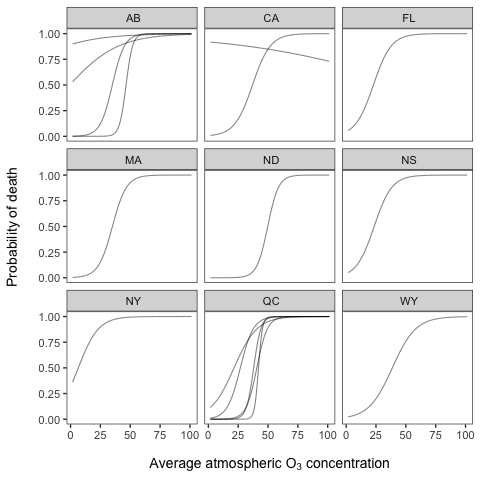

In [98]:
%%R
p5 <- ggplot(predictions_data, aes(x = o3_average, y = predicted, group = operation_id)) +
  geom_line(alpha = 0.5) +
  labs(
    x = expression("Average atmospheric O"[3] * " concentration"),
    y = "Probability of death\n"
  ) +
  scale_y_continuous(breaks = seq(0, 1, 0.25), limits = c(0, 1)) +
  facet_wrap(~region) +
  theme_bw(base_size = 14) +
  theme(
    legend.position = "none",
    panel.grid = element_blank(),
    axis.title.x = element_text(margin = margin(t = 16))
  )
p5

### SAVE PLOTS

In [101]:
%%R
figure <- ggarrange(
    p1, p2,
    ncol = 2,
    nrow = 1
)

filename <- file.path("..", "outputs", "figure1.png")
ggexport(
    figure,
    filename = filename,
    res = 270,
    width = 2400,
    height = 1200
)

file saved to ../outputs/figure1.png


In [102]:
%%R
file_path <- file.path("..", "outputs")

ggsave(filename = file.path(file_path, "figure4.png"), plot = p4, width = 6, height = 6)
ggsave(filename = file.path(file_path, "figure5.png"), plot = p5, width = 8, height = 8)
ggsave(filename = file.path(file_path, "figure7.png"), plot = p7, width = 6, height = 4)